# Predict COVID-19 Growth in Illinois Using a Generalized Logistic Growth Model

**Author: Ming-Sen Wang, Economist/Data Scientist**

This "shelter-in-place" project aims at developing a simple structural model to project the trajectory of the COVID-19 confirmed cases in Illinois and, hence, to assess at which stage of the epidemic is for Illnois.

The model calibrates a Generalized Logistic Growth Model to fit the data extracted from GitHub of New Times.  From the time series data, the model structurally describes how many people an infected person can potentially encounter and among those how likely one can be infected.

The model assumes that there is no interstate movement by fixing Illinois's population at 12.74 million and that the growth slows down as the number of infected increases.  In addition, the model does not know any policy changes during the data periods, such as Governor Pritzker's "shelter-in-place" executive order.

The Generalized Logistic Growth Model is estimated using different estimation strategies to demonstrate the thought process and the pitfalls of the model.  The projected trajectory of the confirmed cases is  an extrapolation based on the model structure.  A main challenge is that the data at this early stage cannot distinguish different model parameters that generate very different trajectories, which is the identification problem.  Therefore, different estimation strategies can shade lights on the uncertainty around the projections.

# Data Processing

U.S. Data is obtained from New York Times as of 4/10.  The trend of interest starts at the 100th confirmed cases.

In [1]:
!pip install arviz

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import pystan as ps
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

data = pd.read_csv('/content/gdrive/My Drive/Data/us-states.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Set Parameters

In [0]:
init0 = 100
days_pred = 45

In [4]:
ildata = data[data['state'] == 'Illinois'][data['cases'] >= init0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [0]:
all_days = ildata.shape[0] + days_pred

In [0]:
xaxis = [np.datetime64(ildata.date.min()) + np.timedelta64(i, 'D') for i in range(all_days)]
xhist = [np.datetime64(x) for x in ildata['date'].values]

# Structural Model

The model assumes that an infected is expected to encounter $r$ people by many means -- such as walking near one person within 1 meter, talking to a person, touching a handrail that 20 others touch in an hour, etc. -- throughout a day.  Among those encountered, a proportion $P$ of them would be infected and bcomes new cases.

Denote the total confirmed cases at day $t$ as $C(t)$; expected number of encounters of someone infected as $r$; the probability of an encounter contracting the virus as $P$.

Then on a given day $t$, the number of new cases is $r \cdot P \cdot C(t)$.  The total confirmed cases on the next day will be $C(t+1)  = C(t) + r \cdot P \cdot C(t)$.

Assume the probability of contraction decays as the number of confirmed cases increases: $P = 1 - \left(\frac{C(t)}{K}\right)^\alpha$, where $K = \kappa \cdot \text{Population}$.  $\alpha$ is the tuning parameter that controls the rate of decay as a function of the number of current confirmed cases.

Mathematically, the model can be written as
$C(t+1)  = C(t) + r \cdot \left( 1 - \left(\frac{C(t)}{\kappa \cdot \text{Population}}\right)^\alpha \right) \cdot C(t)$.

# Estimation Strategy: Baseline Model

This model minimizes the error sum of squares between the calibrated trajectories and the actual trajectories.  The model parameters are estimated by the data without imposing any additional assumptions beyond the structural model.

In [0]:
from scipy.stats import beta
from scipy import optimize

def logistic_growth(init0, pop, theta, N):
  gamma = theta[0]
  kappa = theta[1]
  alpha = theta[2]

  y_pred = []
  y_now = init0
  for i in range(N):
    y_next = (1 + gamma * (1 - (y_now/(kappa * pop))**alpha)) * y_now
    y_now = y_next
    y_pred.append(y_next)

  return y_pred

def value_func(y, init0, pop, theta):
    N = len(y)
    y_pred = logistic_growth(init0, pop, theta, N)
    val = np.sqrt(np.mean([(a - b) **2 for a, b in zip(y_pred, y)]))
    return val

In [8]:
y = ildata.loc[:,'cases'] 
fit = optimize.minimize(
    fun = lambda theta: value_func(y/10000, init0/10000, 1274, theta),
    x0 = [500/10000, 0.04, 1], 
    method='SLSQP', 
    bounds= ((0, np.inf), (0, 1), (0, 1)), 
    tol = 1E-12,
    options={'maxiter': 1000}
    )

print(fit)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


     fun: 0.01183318059345243
     jac: array([-0.00135917, -1.01582265, -0.9012702 ])
 message: 'Optimization terminated successfully.'
    nfev: 2671
     nit: 491
    njev: 491
  status: 0
 success: True
       x: array([7.30823979e+00, 3.61475406e-03, 1.05583537e-02])


In [0]:
y_pred = np.array([x * 10000 for x in logistic_growth(init0/10000, 1274, fit['x'], all_days)])

Text(0, 0.5, 'Total Confirmed Cases')

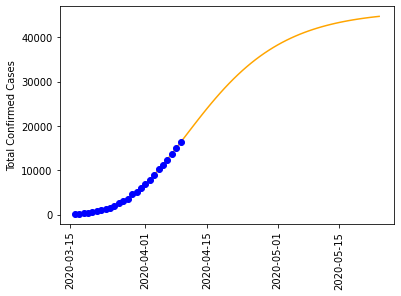

In [10]:
plt.figure()
plt.plot(xaxis, y_pred, label = 'Mean', color = 'orange')

plt.plot(xhist, ildata['cases'], 'bo')
plt.xticks(rotation = 90)

plt.xlabel('')
plt.ylabel('Total Confirmed Cases')

Text(0, 0.5, 'New Confirmed Cases')

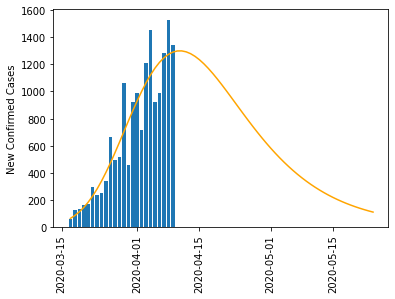

In [11]:
plt.figure()
plt.plot(xaxis[1:], np.diff(y_pred), label = 'Mean', color = 'orange')

plt.bar(xhist[1:], np.diff(ildata['cases']))
plt.xticks(rotation = 90)

plt.xlabel('')
plt.ylabel('New Confirmed Cases')

# Estimation Strategy: IHME

This model assumes that 0.88% of the Illinois population will be infected by the disease so as to incorporate the IHME projections into the model.

In [0]:
kappa = 0.0088

In [0]:
def logistic_growth_ihme(init0, pop, theta, kappa, N):
  gamma = theta[0]
  alpha = theta[1]

  y_pred = []
  y_now = init0
  for i in range(N):
    y_next = (1 + gamma * (1 - (y_now/(kappa * pop))**alpha)) * y_now
    y_now = y_next
    y_pred.append(y_next)

  return y_pred

def value_func_ihme(y, init0, pop, theta, kappa):
    N = len(y)
    y_pred = logistic_growth_ihme(init0, pop, theta, kappa, N)
    val = np.sqrt(np.mean([(a - b) **2 for a, b in zip(y_pred, y)]))
    return val

In [14]:
y = ildata.loc[:,'cases'] 
fit_ihme = optimize.minimize(
    fun = lambda theta: value_func_ihme(y/10000, init0/10000, 1274, theta, kappa),
    x0 = [500/10000, 0.04], 
    method='SLSQP', 
    bounds= ((0, np.inf), (0, 1)), 
    tol = 1E-12,
    options={'maxiter': 5000}
    )

print(fit_ihme)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars


     fun: 0.04942812459347964
     jac: array([-8.44895840e-06,  2.12918641e-01])
 message: 'Optimization terminated successfully.'
    nfev: 4909
     nit: 739
    njev: 739
  status: 0
 success: True
       x: array([1.27689383e+02, 4.50568189e-04])


In [0]:
y_pred = np.array([x * 10000 for x in logistic_growth_ihme(init0/10000, 1274, fit_ihme['x'], kappa, all_days)])

Text(0, 0.5, 'Total Confirmed Cases')

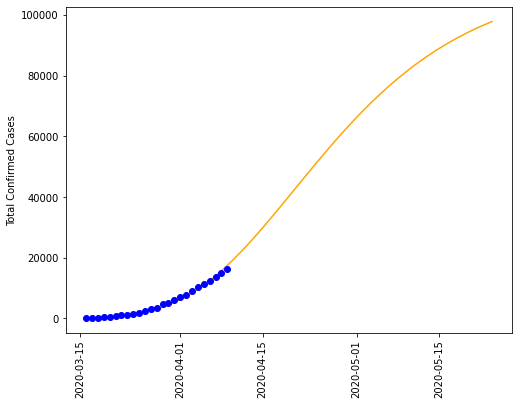

In [16]:
plt.figure(figsize = (8, 6))
plt.plot(xaxis, y_pred, label = 'Mean', color = 'orange')

plt.plot(xhist, ildata['cases'], 'bo')
plt.xticks(rotation = 90)

plt.xlabel('')
plt.ylabel('Total Confirmed Cases')

Text(0, 0.5, 'New Confirmed Cases')

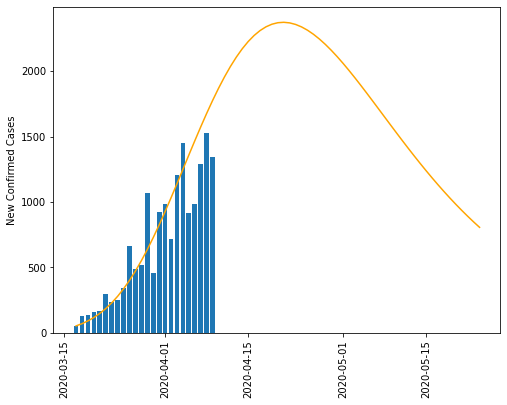

In [17]:
plt.figure(figsize = (8, 6))
plt.plot(xaxis[1:], np.diff(y_pred), label = 'Mean', color = 'orange')

plt.bar(xhist[1:], np.diff(ildata['cases']))
plt.xticks(rotation = 90)

plt.xlabel('')
plt.ylabel('New Confirmed Cases')

# Estimation Strategy: Bayesian Model

This model uses a Bayesian approach to estimate the parameters.  We impose priors on the paramters as follows:

$\alpha \sim Beta(2, 2)$

$\kappa \sim Beta(2, 2)$

$\gamma \sim Exponential(4)$

The errors between the calibrated trend and the actual trend are assume to follows a normal distribution with $\sigma \sim Half t(4, 0, 1)$.

In [0]:
pub = 0.975
plb = 0.025

In [0]:
y = ildata['cases']
stan_data = dict(
    N = len(y),
    y = [x/10000 for x in y.values],
    N_pred = days_pred
)

In [0]:
model_code = """
data {
  int<lower=0> N;
  vector[N] y;
  int<lower=0> N_pred;
}
parameters {
  real<lower=0, upper = 1> alpha; 
  real<lower=0, upper = 1> kappa;
  real<lower=0> gamma;
  real<lower=0> sigma;
}
transformed parameters {
  real y_pred[N];
  y_pred[1] <- 0.01;
  for (i in 2:N) {
     y_pred[i] <- y_pred[i - 1] + gamma * (1 - ((y_pred[i-1])/(kappa * 1274))^alpha) * y_pred[i-1];
  }
}
model {
  gamma ~ exponential(4); # normal(1, 10)
  alpha ~ beta(2, 2);
  kappa ~ beta(2, 2);
  sigma ~ student_t(4, 0, 1);
  y ~ normal(y_pred, sigma);
}
generated quantities {
  vector[N + N_pred] y_hat;
  y_hat[1] <- 0.01; 
  for(i in 2:(N + N_pred)) {
    y_hat[i] <- y_hat[i - 1] + gamma * (1 - ((y_hat[i-1])/(kappa * 1274))^alpha) * y_hat[i-1];
  }
}
"""

In [21]:
iter = 4000
model = ps.StanModel(model_code=model_code)
trace = model.sampling(
    data=stan_data, 
    chains = 4, 
    iter = iter, 
    warmup = int(np.floor(iter/2)), 
    thin = 1, 
    seed = 42, 
    control = dict(
        adapt_delta= 0.95,
        max_treedepth = 20
    )
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c27e3fde412008ceeda93b6ecb266d07 NOW.


In [22]:
print(trace.stansummary(pars = ['alpha', 'kappa', 'gamma', 'sigma']))

Inference for Stan model: anon_model_c27e3fde412008ceeda93b6ecb266d07.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.09  8.7e-4   0.03   0.05   0.07   0.09   0.11   0.17   1487    1.0
kappa 2.5e-3  4.5e-6 1.8e-4 2.1e-3 2.4e-3 2.5e-3 2.6e-3 2.8e-3   1637    1.0
gamma   1.26  8.7e-3   0.35   0.72    1.0    1.2   1.46   2.11   1660    1.0
sigma   0.02  9.0e-5 3.8e-3   0.02   0.02   0.02   0.02   0.03   1778    1.0

Samples were drawn using NUTS at Sun Apr 12 03:25:07 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2dbe5d3a90>,
      dtype=object)

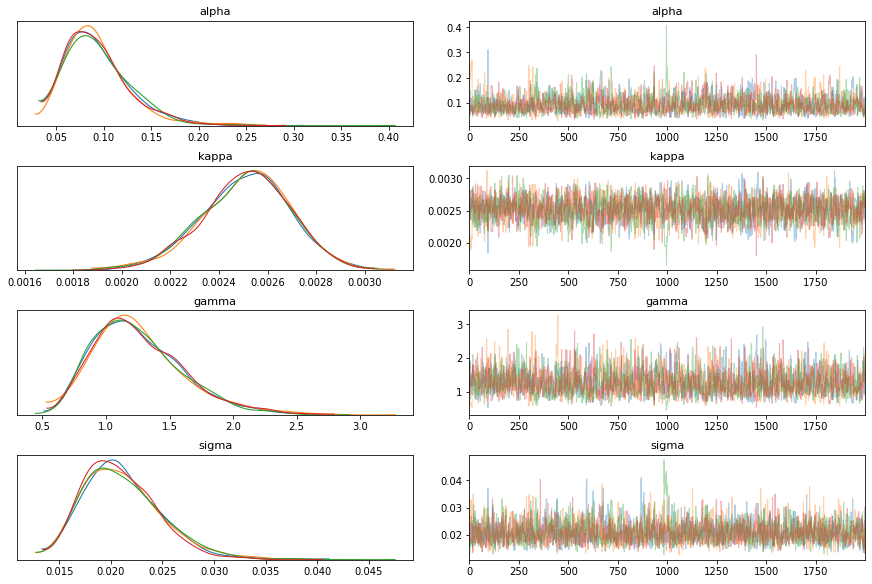

In [23]:
az.plot_trace(trace, var_names = ['alpha', 'kappa', 'gamma', 'sigma'])

In [0]:
post_df = trace.to_dataframe()
sel_cols = [col for col in post_df.columns if 'y_hat' in col]
lb = post_df.loc[:, sel_cols].quantile(q = plb, axis = 0) * 10000
ub = post_df.loc[:, sel_cols].quantile(q = pub, axis = 0) * 10000
avg = post_df.loc[:, sel_cols].mean() * 10000

Text(0, 0.5, 'Total Confirmed Cases')

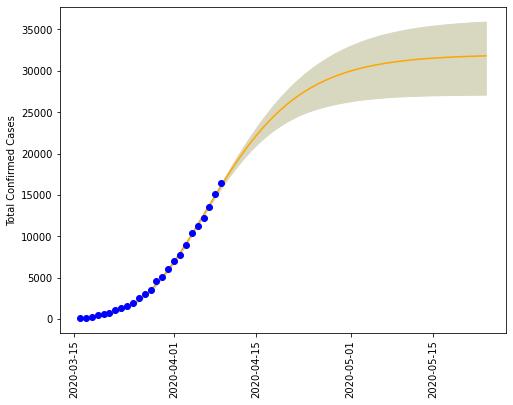

In [25]:
plt.figure(figsize = (8, 6))
plt.fill_between(xaxis, lb, ub, color = '#d8d7bf')
plt.plot(xaxis, avg, label = 'Mean', color = 'orange')

plt.plot(xhist, ildata['cases'], 'bo')
plt.xticks(rotation = 90)

plt.xlabel('')
plt.ylabel('Total Confirmed Cases')

In [0]:
n_diff = np.diff(post_df.loc[:, sel_cols].values, axis = 1)
dub = np.quantile(n_diff, q = plb, axis = 0) * 10000
dlb = np.quantile(n_diff, q = pub, axis = 0) * 10000

Text(0, 0.5, 'New Confirmed Cases')

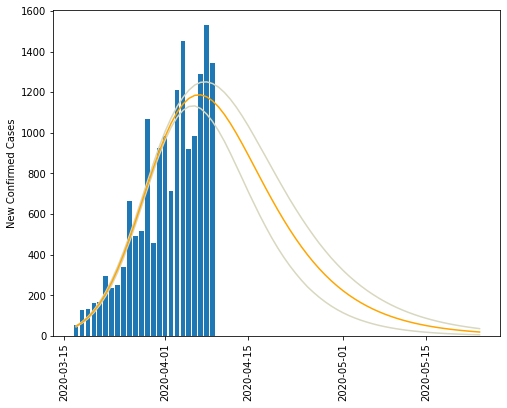

In [27]:
plt.figure(figsize = (8, 6))
plt.plot(xaxis[1:], dlb, label = 'Lower Bound', color = '#d8d7bf')
plt.plot(xaxis[1:], dub, label = 'Upper Bound', color = '#d8d7bf')
plt.plot(xaxis[1:], np.diff(avg), label = 'Mean', color = 'orange')

plt.bar(xhist[1:], np.diff(ildata['cases']))
plt.xticks(rotation = 90)

plt.xlabel('')
plt.ylabel('New Confirmed Cases')

In [0]:
trace_bayes = trace

# Estimation Strategy: Multilevel Bayesian Model

This model utilizes trajectories of New York state and California to inform the trajectory of Illinois.  The idea is to use states that are similar to Illinois and ahead in the infection stage to inform Illinois's trajectory.

In [29]:
sel_states = ['New York', 'Illinois', 'California', ] # 'Washington' 
stdata = data[data['date'] >="2020-03-01"][data['state'].isin(sel_states)]
print(stdata[['date', 'state']].groupby('state').count())
print(stdata[['cases', 'state']].groupby('state').min())

            date
state           
California    40
Illinois      40
New York      40
            cases
state            
California     33
Illinois        3
New York        1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [30]:
stdata['state_ix'] = pd.Categorical(stdata.state).codes + 1
pd.Categorical(stdata.state)

[California, Illinois, New York, California, Illinois, ..., Illinois, New York, California, Illinois, New York]
Length: 120
Categories (3, object): [California, Illinois, New York]

In [0]:
y_list = [
          [x/10000 for x in stdata.loc[stdata['state_ix'] == j, 'cases'].values] for j in range(1, len(sel_states)+1)
]

In [0]:
stan_data = dict(
    N = len(y_list[0]),
    N_state = len(sel_states),
    state_ix = [1 + i for i in range(len(sel_states))],
    y = y_list,
    N_hist = len(y), # use this to match days in the history of the previous models
    N_pred = days_pred,
    pop = [3956, 1274, 999, ], #754
    y0 = stdata[['cases', 'state']].groupby('state').min().values.reshape(1, -1)[0]
)

In [0]:
model_code = """
data {
  int<lower=0> N; 
  int<lower=0> N_state;
  int<lower=1, upper=N_state> state_ix[N_state];
  vector[N] y[N_state];
  int<lower=0> N_hist;
  int<lower=0> N_pred;
  vector[N_state] pop;
  vector[N_state] y0;
}
parameters {
  real<lower=0, upper = 1> alpha[N_state]; 
  real<lower=0> sigma;
  real<lower=0, upper = 1> kappa[N_state];
  real<lower=0> gamma[N_state];
}
transformed parameters {
  vector[N] y_pred[N_state];
  for(j in 1:N_state) {
    y_pred[j][1] <- y0[j]/10000;
    for (i in 2:N) {
       y_pred[j][i] <- y_pred[j][i - 1] + gamma[j] * (1 - ((y_pred[j][i-1])/(kappa[j] * pop[j]))^alpha[j]) * y_pred[j][i-1];
    }
  }
  
}
model {
  sigma ~ student_t(4, 0, 1);
  for(j in 1:N_state) {
    alpha[j] ~ beta(2, 2);
    gamma[j] ~ exponential(2);
    kappa[j] ~ beta(1, 9);
    y[j] ~ normal(y_pred[j], sigma);
  }
}
generated quantities {
  vector[N_hist + N_pred] y_hat[N_state];
  for(j in 1:N_state) {
      y_hat[j][1] <- 0.01; 
      for(i in 2:(N_hist + N_pred)) {
        y_hat[j][i] <- y_hat[j][i - 1] + gamma[j] * (1 - ((y_hat[j][i-1])/(kappa[j] * pop[j]))^alpha[j]) * y_hat[j][i-1];
      }
  }
}
"""

In [34]:
iter = 2000
model = ps.StanModel(model_code=model_code)
trace = model.sampling(
    data=stan_data, 
    chains = 4, 
    iter = iter, 
    warmup = int(np.floor(iter/2)), 
    thin = 1, 
    seed = 42, 
    control = dict(
        adapt_delta= 0.99,
        max_treedepth = 15
    )
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2c40b0b9cc67506cd31a1db037b18c43 NOW.


In [35]:
print(trace.stansummary(pars = ['alpha', 'kappa', 'gamma', 'sigma']))

Inference for Stan model: anon_model_2c40b0b9cc67506cd31a1db037b18c43.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]   0.54  8.4e-3   0.21   0.12   0.38   0.56    0.7   0.91    649    1.0
alpha[2]   0.29  5.4e-3   0.17   0.06   0.17   0.27    0.4   0.68    924    1.0
alpha[3]   0.04  2.0e-4 7.5e-3   0.03   0.04   0.04   0.05   0.06   1343    1.0
kappa[1] 1.3e-3  5.1e-5 1.0e-3 6.6e-4 7.9e-4 9.4e-4 1.3e-3 4.0e-3    397   1.01
kappa[2] 3.6e-3  8.0e-5 2.2e-3 1.6e-3 2.2e-3 2.9e-3 4.3e-3 9.5e-3    773    1.0
kappa[3]   0.03  1.6e-5 6.0e-4   0.02   0.03   0.03   0.03   0.03   1375    1.0
gamma[1]   0.26  4.4e-3   0.08   0.22   0.23   0.24   0.26   0.44    360   1.01
gamma[2]   0.46  6.7e-3   0.19   0.31   0.35    0.4    0.5   0.99    796    1.0
gamma[3]   2.39    0.01   0.39   1.81   2.12   2.33    2.6   3.28   1273    1.0
sigma      

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2db91a8978>,
      dtype=object)

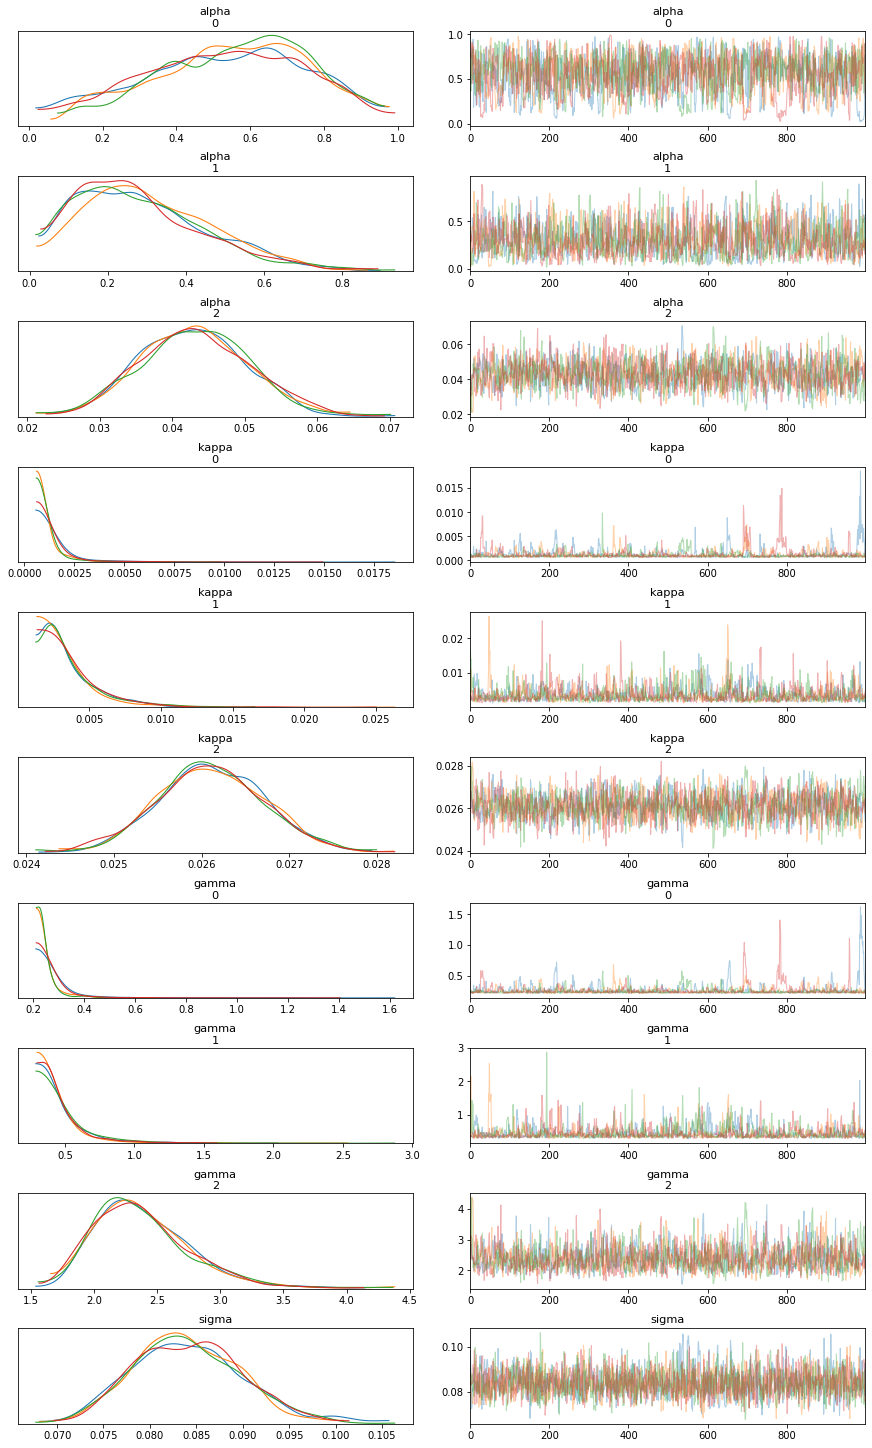

In [36]:
az.plot_trace(trace, var_names = ['alpha', 'kappa', 'gamma', 'sigma'])

In [0]:
post_df = trace.to_dataframe()
sel_cols = [col for col in post_df.columns if 'y_hat[2,' in col]
lb = post_df.loc[:, sel_cols].quantile(q = plb, axis = 0) * 10000
ub = post_df.loc[:, sel_cols].quantile(q = pub, axis = 0) * 10000
avg = post_df.loc[:, sel_cols].mean() * 10000

Text(0, 0.5, 'Total Confirmed Cases')

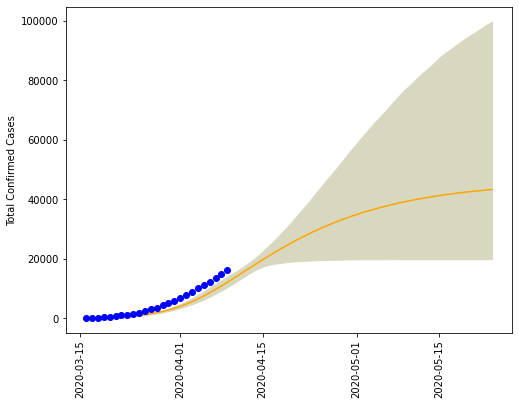

In [38]:
plt.figure(figsize = (8, 6))
plt.fill_between(xaxis, lb, ub, color = '#d8d7bf')
plt.plot(xaxis, avg, label = 'Mean', color = 'orange')

plt.plot(xhist, ildata['cases'], 'bo')
plt.xticks(rotation = 90)

plt.xlabel('')
plt.ylabel('Total Confirmed Cases')

In [0]:
n_diff = np.diff(post_df.loc[:, sel_cols].values, axis = 1)
dub = np.quantile(n_diff, q = plb, axis = 0) * 10000
dlb = np.quantile(n_diff, q = pub, axis = 0) * 10000

Text(0, 0.5, 'New Confirmed Cases')

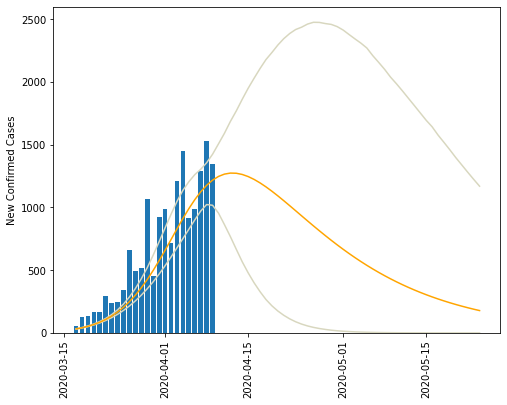

In [40]:
plt.figure(figsize = (8, 6))
plt.plot(xaxis[1:], dlb, label = 'Lower Bound', color = '#d8d7bf')
plt.plot(xaxis[1:], dub, label = 'Upper Bound', color = '#d8d7bf')
plt.plot(xaxis[1:], np.diff(avg), label = 'Mean', color = 'orange')

plt.bar(xhist[1:], np.diff(ildata['cases']))
plt.xticks(rotation = 90)

plt.xlabel('')
plt.ylabel('New Confirmed Cases')

In [0]:
trace_hier = trace

# Summary of Results

Text(0, 0.5, 'Total Confirmed Cases')

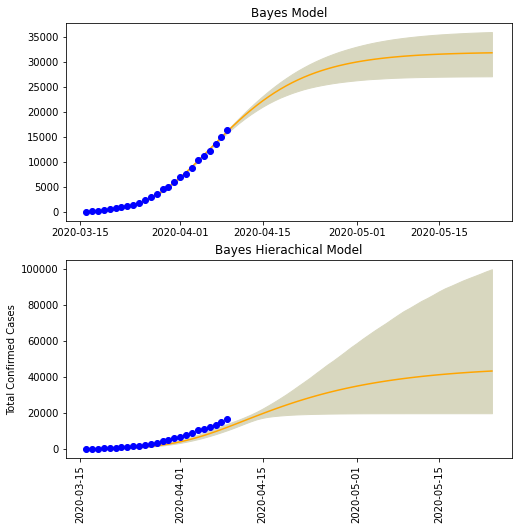

In [42]:
plt.figure(figsize = (8, 8))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

post_df = trace_bayes.to_dataframe()
sel_cols = [col for col in post_df.columns if 'y_hat' in col]
lb = post_df.loc[:, sel_cols].quantile(q = plb, axis = 0) * 10000
ub = post_df.loc[:, sel_cols].quantile(q = pub, axis = 0) * 10000
avg = post_df.loc[:, sel_cols].mean() * 10000

ax1.fill_between(xaxis, lb, ub, color = '#d8d7bf')
ax1.plot(xaxis, avg, label = 'Mean', color = 'orange')
ax1.plot(xhist, ildata['cases'], 'bo')
ax1.set_title('Bayes Model')


post_df = trace_hier.to_dataframe()
sel_cols = [col for col in post_df.columns if 'y_hat[2' in col]
lb = post_df.loc[:, sel_cols].quantile(q = plb, axis = 0) * 10000
ub = post_df.loc[:, sel_cols].quantile(q = pub, axis = 0) * 10000
avg = post_df.loc[:, sel_cols].mean() * 10000

plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Total Confirmed Cases')

ax2.fill_between(xaxis, lb, ub, color = '#d8d7bf')
ax2.plot(xaxis, avg, label = 'Mean', color = 'orange')
ax2.plot(xhist, ildata['cases'], 'bo')
ax2.set_title('Bayes Hierachical Model')

plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Total Confirmed Cases')